In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score,
                             recall_score, precision_score, f1_score)
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import BertTokenizer, BertModel,  AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from pathlib import Path
import os

import torch
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Display all columns in DataFrame
pd.set_option('display.max_columns', None)

Mounted at /content/drive


In [2]:

dir = Path("/content/drive/MyDrive/")
output_dir = dir / "Experiments_with_categories"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' created.")
else:
    print(f"Directory '{output_dir}' already exists.")

Directory '/content/drive/MyDrive/Experiments_with_categories' already exists.


In [3]:
df_original = pd.read_csv(dir / "banrkupcy_dataset.csv")

In [4]:
df_original

,year,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,bankruptcy
0,1,0.200550,0.37951,0.396410,2.04720,32.3510,0.38825,0.249760,1.33050,1.13890,0.504940,0.249760,0.659800,0.166600,0.249760,497.42,0.733780,2.63490,0.249760,0.149420,43.3700,1.24790,0.214020,0.119980,0.47706,0.504940,0.604110,1.45820,1.761500,5.9443,0.11788,0.149420,94.140,3.8772,0.56393,0.214020,1.74100,593.27000,0.50591,0.128040,0.662950,0.051402,0.128040,114.420,71.0500,1.00970,1.52250,49.394,0.185300,0.110850,2.04200,0.37854,0.25792,2.24370,2.24800,348690.00,0.121960,0.397180,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.42770,0
1,1,0.209120,0.49988,0.472250,1.94470,14.7860,0.00000,0.258340,0.99601,1.69960,0.497880,0.261140,0.516800,0.158350,0.258340,677.96,0.538380,2.00050,0.258340,0.152000,87.9810,1.42930,0.248060,0.123040,NaN,0.395420,0.439920,88.44400,16.946000,3.6884,0.26969,0.152000,122.170,2.9876,2.98760,0.206160,1.69960,NaN,0.49788,0.121300,0.086422,0.064371,0.145950,199.490,111.5100,0.51045,1.12520,100.130,0.237270,0.139610,1.94470,0.49988,0.33472,17.86600,17.86600,2304.60,0.121300,0.420020,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.98700,0
2,1,0.248660,0.69592,0.267130,1.55480,-1.1523,0.00000,0.309060,0.43695,1.30900,0.304080,0.312580,0.641840,0.244350,0.309060,794.16,0.459610,1.43690,0.309060,0.236100,73.1330,1.42830,0.302600,0.189960,NaN,0.289320,0.372820,86.01100,1.062700,4.3749,0.41929,0.238150,176.930,2.0630,1.42740,0.315650,1.30900,2.30190,0.51537,0.241140,0.322020,0.074020,0.231170,165.510,92.3810,0.94807,1

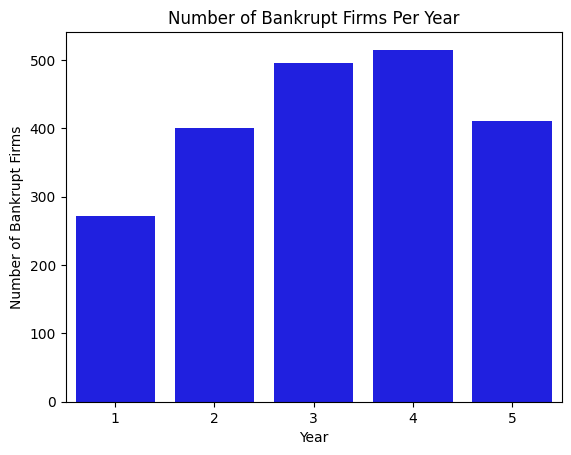

In [8]:
df_bankrupt = df_original[df_original['bankruptcy'] == 1]
bankrupt_count = df_bankrupt.groupby('year').size().reset_index(name='Count')

# Create the plot
sns.barplot(data=bankrupt_count, x='year', y='Count', color='blue')
plt.title('Number of Bankrupt Firms Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Bankrupt Firms')
plt.show()

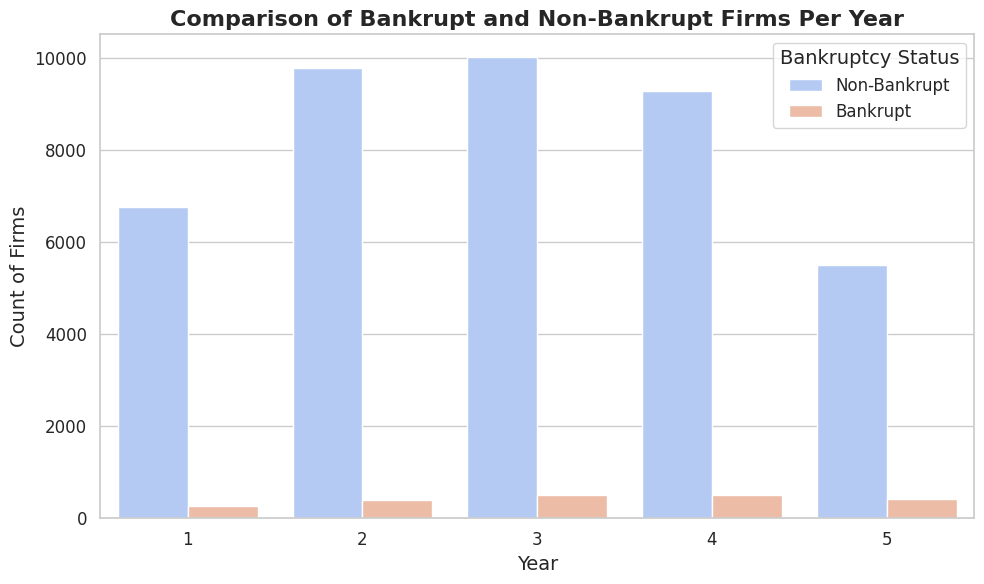

In [13]:
df = df_original.copy()
yearly_counts = df.groupby(['year', 'bankruptcy']).size().reset_index(name='Count')

# Set a theme for better aesthetics
sns.set_theme(style='whitegrid')

# Create the plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=yearly_counts, x='year', y='Count', hue='bankruptcy', palette='coolwarm')

# Add titles and labels with improved formatting
plt.title('Comparison of Bankrupt and Non-Bankrupt Firms Per Year', fontsize=16, weight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count of Firms', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Customize the legend to use color patches
handles, labels = barplot.get_legend_handles_labels()
plt.legend(handles, ['Non-Bankrupt', 'Bankrupt'], title='Bankruptcy Status', fontsize=12, title_fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
print(df_original.shape)
df_original.head()

(43405, 66)


,year,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,bankruptcy
0,1,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,0.249760,0.65980,0.166600,0.249760,497.42,0.73378,2.6349,0.249760,0.149420,43.370,1.2479,0.21402,0.119980,0.47706,0.50494,0.60411,1.45820,1.7615,5.9443,0.11788,0.149420,94.14,3.8772,0.56393,0.21402,1.7410,593.2700,0.50591,0.128040,0.662950,0.051402,0.128040,114.42,71.050,1.00970,1.52250,49.394,0.185300,0.110850,2.0420,0.37854,0.25792,2.2437,2.2480,348690.0,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,0.261140,0.51680,0.158350,0.258340,677.96,0.53838,2.0005,0.258340,0.152000,87.981,1.4293,0.24806,0.123040,NaN,0.39542,0.43992,88.44400,16.9460,3.6884,0.26969,0.152000,122.17,2.9876,2.98760,0.20616,1.6996,NaN,0.49788,0.121300,0.086422,0.064371,0.145950,199.49,111.510,0.51045,1.12520,100.130,0.237270,0.139610,1.9447,0.49988,0.33472,17.8660,17.8660,2304.6,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,1,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,0.312580,0.64184,0.244350,0.309060,794.16,0.45961,1.4369,0.309060,0.236100,73.133,1.4283,0.30260,0.189960,NaN,0.28932,0.37282,86.01100,1.0627,4.3749,0.41929,0.238150,176.93,2.0630,1.42740,0.31565,1.3090,2.3019,0.51537,0.241140,0.322020,0.074020,0.231170,165.51,92.381,0.94807,1.01010,96.372,0.291810,0.222930,1.0758,0.48152,0.48474,1.2098,2.0504,63

# Functions

## Splitting and undersampling

In [ ]:
def split_data_by_year(df, train_years=range(1, 4), test_years=range(4, 11)):
    """
    Splits the data into training and testing datasets based on specified year ranges.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        train_years (iterable, optional): Years to include in the training set (default: range(1, 4)).
        test_years (iterable, optional): Years to include in the testing set (default: range(4, 11)).

    Returns:
        tuple: A tuple containing the training DataFrame and the testing DataFrame.
    """
    train_df = df[df['year'].isin(train_years)].copy()
    test_df = df[df['year'].isin(test_years)].copy()
    return train_df, test_df


train_df, test_df = split_data_by_year(df_original)

print("Training set:")
print(train_df['bankruptcy'].value_counts())
print("\nTesting set:")
print(test_df['bankruptcy'].value_counts())

Training set:
bankruptcy
0    26537
1     1166
Name: count, dtype: int64

Testing set:
bankruptcy
0    14777
1      925
Name: count, dtype: int64


In [ ]:
def balance_data(data):
    balanced_train_df = pd.DataFrame(columns=data.columns)
    years = data['year'].unique()

    for year in years:
        year_data = data[data['year'] == year]
        bankruptcy = year_data[year_data['bankruptcy'] == 1]
        non_bankruptcy = year_data[year_data['bankruptcy'] == 0]
        n_bankruptcy = len(bankruptcy)

        if n_bankruptcy == 0:
            print(f"Year {year} has no bankruptcy cases. Skipping under-sampling.")
            continue

        non_bankruptcy_sampled = non_bankruptcy.sample(n=n_bankruptcy, random_state=42)
        balanced_year_df = pd.concat([bankruptcy, non_bankruptcy_sampled], axis=0)
        balanced_train_df = pd.concat([balanced_train_df, balanced_year_df], axis=0)

    balanced_train_df = balanced_train_df.sample(frac=1, random_state=42)
    return balanced_train_df


balanced_train_df = balance_data(train_df)
print("\nBalanced Training set:")
print(balanced_train_df['bankruptcy'].value_counts())


Balanced Training set:
bankruptcy
1    1166
0    1166
Name: count, dtype: int64


<ipython-input-18-febdd1b0b601>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  balanced_train_df = pd.concat([balanced_train_df, balanced_year_df], axis=0)


In [ ]:


print(balanced_train_df.shape)
print(test_df.shape)

(2332, 66)
(15702, 66)


In [ ]:
# this puts the train and test together. the train has been undersampled such that the distributions are equal. subsample is random
df_all = pd.concat([balanced_train_df, test_df])

In [ ]:
##### NOTE #######
# # TO BE REMOVED WHEN RUNNING ALL
# The following is to create a subset of the data to test the embedding funcions. But should be removed to get embeddings on all data

# df_all = pd.concat([
#   balanced_train_df.sample(frac=0.05, random_state=42),
#   test_df.sample(frac=0.01, random_state=42)
# ])

## Text Processing for TabText

In [ ]:
# Define all ratios grouped by category
profitability_efficiency = [
    'net profit / total assets', 'EBIT / total assets', 'gross profit / total assets',
    'profit on operating activities / total assets', 'net profit / sales',
    'profit on sales / total assets', 'profit on sales / sales', 'sales / total assets',
    '(gross profit + depreciation) / sales', '(gross profit + interest) / total assets',
    '(gross profit + interest) / sales', 'EBITDA (profit on operating activities - depreciation) / total assets',
    'EBITDA (profit on operating activities - depreciation) / sales',
    '(sales - cost of products sold) / sales', 'total costs / total sales',
    'gross profit / short-term liabilities', 'gross profit (in 3 years) / total assets',
    '(gross profit + depreciation) / total liabilities', 'gross profit / sales',
    'profit on operating activities / sales',
]

liquidity_working_capital = [
    'working capital / total assets', 'current assets / short-term liabilities',
    '(current assets - inventory) / short-term liabilities', 'current assets / total liabilities',
    'working capital / fixed assets', 'working capital',
    '[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365',
    '(current assets - inventories) / long-term liabilities',
    '(current assets - inventory - receivables) / short-term liabilities',
    '(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)',
    'sales / short-term liabilities',
]

capital_structure_leverage = [
    'total liabilities / total assets', 'equity / total assets',
    'book value of equity / total liabilities', 'total assets / total liabilities',
    'long-term liabilities / equity', '(equity - share capital) / total assets',
    'short-term liabilities / total assets', 'equity / fixed assets',
    'constant capital / fixed assets', 'constant capital / total assets',
    'retained earnings / total assets', '(total liabilities - cash) / sales',
    'total liabilities / ((profit on operating activities + depreciation) * (12/365))'
]

asset_management_turnover = [
    '(inventory * 365) / sales', '(receivables * 365) / sales',
    '(inventory * 365) / cost of products sold', 'rotation receivables + inventory turnover in days',
    '(current liabilities * 365) / cost of products sold', '(short-term liabilities * 365) / cost of products sold',
    '(short-term liabilities * 365) / sales', '(total liabilities * 365) / (gross profit + depreciation)',
    'sales / inventory', 'sales / receivables', 'sales / fixed assets', 'sales (n) / sales (n-1)',
    '(gross profit + extraordinary items + financial expenses) / total assets',
    '(net profit + depreciation) / total liabilities', 'profit on operating activities / financial expenses',
    'operating expenses / short-term liabilities', 'operating expenses / total liabilities',
    'net profit / inventory', 'logarithm of total assets', 'total sales / total assets'
]

# Combine all the categories into one list
all_ratios = (
    profitability_efficiency +
    liquidity_working_capital +
    capital_structure_leverage +
    asset_management_turnover
)

# Create a dictionary to map each ratio to its category
ratio_categories = {}
for ratio in profitability_efficiency:
    ratio_categories[ratio] = 'Profitability Ratios'
for ratio in liquidity_working_capital:
    ratio_categories[ratio] = 'Liquidity Ratios'
for ratio in capital_structure_leverage:
    ratio_categories[ratio] = 'Leverage Ratios'
for ratio in asset_management_turnover:
    ratio_categories[ratio] = 'Efficiency Ratios'


In [ ]:
# Function to generate explanations for each ratio
def generate_explanation(ratio_name):
    # Clean up the ratio name for better readability
    ratio_cleaned = ratio_name.replace('(', '').replace(')', '')
    ratio_cleaned = ratio_cleaned.replace('/', ' divided by ')
    ratio_cleaned = ratio_cleaned.replace('*', ' multiplied by ')
    ratio_cleaned = ratio_cleaned.replace('  ', ' ').strip()
    # Capitalize the first letter
    ratio_cleaned = ratio_cleaned[0].upper() + ratio_cleaned[1:]
    # Generate an explanation
    return f"The ratio of {ratio_cleaned} is {{value}}."

# Generate the 'all_text' column
def generate_all_text(row):
    intro = "We are analyzing the financial health of a company to assess its risk of bankruptcy. These are the key financial ratios and indicators of the company. "

    # Initialize a dictionary to hold texts for each category
    category_texts = {
        'Profitability Ratios': [],
        'Liquidity Ratios': [],
        'Leverage Ratios': [],
        'Efficiency Ratios': []
    }

    # Iterate over all ratios
    for ratio in all_ratios:
        value = row.get(ratio)
        if pd.notnull(value):
            rounded_value = round(value, 4)  # Adjust the number of decimal places as needed
            explanation_template = generate_explanation(ratio)
            explanation = explanation_template.format(value=rounded_value)
        else:
            explanation_template = generate_explanation(ratio)
            explanation = explanation_template.format(value="missing")

        category = ratio_categories.get(ratio)
        category_texts[category].append(explanation)

    # Build the full text
    full_text = [intro]
    for category, texts in category_texts.items():
        if texts:
            category_intro = f"{category}:"
            full_text.append(category_intro)
            category_text = ' '.join(texts)
            full_text.append(category_text)

    return ''.join(full_text)

## Embeddings

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
bert_fin_tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
bert_fin_model = AutoModel.from_pretrained("yiyanghkust/finbert-tone")
device = torch.device('cuda' if torch.cuda.is_available() else
                      'cpu')
bert_fin_model.to(device)

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30873, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Function to extract BERT embeddings
def get_bert_embeddings(texts, tokenizer, model):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    # Move inputs to GPU
    inputs = {key: val.to(device) for key, val in inputs.items()}

    bert_model.eval()
    outputs = model(inputs['input_ids'])
    # Use the mean of the last hidden state as the embeddings
    return np.mean(outputs.last_hidden_state.detach().cpu().numpy(), axis=1)

In [ ]:
def create_embeddings(data, tokenizer, model):
    """
    Parameters::
        df: DataFrame with a column named "text"

    Returns::
        emb_df: DataFrame with 768 columns; each row contains the embeddings for the text in the corresponding row of df.
    """
    embeddings = []

    # Loop through the rows of the dataframe. Pass the text through the bert model and get embeddings using the get_bert_embeddings function
    for i in tqdm(range(0, data.shape[0])):
        # print("n.o. sample: ", i)
        text = data.iloc[i]["all_text"]
        full_embedding = get_bert_embeddings(texts=[text], tokenizer=tokenizer, model=model)
        # print(full_embedding.shape)
        embeddings.append(full_embedding.flatten())

    emb_df = pd.DataFrame(np.array(embeddings), columns=[f"emb_{i}" for i in range(768)])

    emb_df = emb_df.set_index(data.index)

    return emb_df

In [ ]:
def get_tokenizer_and_model(model_name):

    if model_name == "bert":
        tokenizer = bert_tokenizer
        model = bert_model
    elif model_name == "finbert":
        tokenizer = bert_fin_tokenizer
        model = bert_fin_model
    else:
        raise ValueError("Invalid combination of tokenizer and model names")

    return tokenizer, model

In [ ]:
def save_raw_data(data, output_dir, experiment_name, model_name):

  df_output_path = output_dir / f"{model_name}_{experiment_name}_df_raw.csv"
  tokenizer, model = get_tokenizer_and_model(model_name)
  print(f"Using model: {model_name} for experiment {experiment_name}")
  print(f"Saving in path: {df_output_path}")

  df_raw = data.copy()
  df_raw['all_text'] = df_raw.apply(generate_all_text, axis=1)
  bert_embeddings = create_embeddings(df_raw, tokenizer, model)

  res = df_raw.merge(bert_embeddings, left_index=True, right_index=True, how="left")
  res.to_csv(df_output_path)

  print(f"Shape of dataframe : {res.shape}")
  print(f"Percentage of null values of tabular data: {100 * data.isna().sum().sum() / data.size:.4f}%")

  return res

In [ ]:
def save_clean_data(data, output_dir, experiment_name, model_name):

  df_output_path = output_dir / f"{model_name}_{experiment_name}_df_clean.csv"
  tokenizer, model = get_tokenizer_and_model(model_name)
  print(f"Using model: {model_name} for experiment {experiment_name}")
  print(f"Saving in path: {df_output_path}")

  df_clean = data.copy()
  df_clean_train, df_clean_test = split_data_by_year(df_clean)

  train_median = df_clean_train.median()
  df_clean_train.fillna(train_median, inplace=True)
  df_clean_test.fillna(train_median, inplace=True)

  df_clean = pd.concat([df_clean_train, df_clean_test])
  assert df_clean.isna().sum().sum() == 0

  df_clean['all_text'] = df_clean.apply(generate_all_text, axis=1)
  bert_embeddings = create_embeddings(df_clean, tokenizer, model)

  res = df_clean.merge(bert_embeddings, left_index=True, right_index=True, how="left")
  res.to_csv(df_output_path)

  print(f"Shape of dataframe : {res.shape}")
  print(f"Percentage of null values : {100 * res.isna().sum().sum() / res.size:.4f}%")

  return res

# Bert

## Plain (2 runs)

### Raw data

In [ ]:
res = save_raw_data(df_all, output_dir, experiment_name="plain", model_name="bert")
res.head()

Using model: bert for experiment plain
Saving in path: /content/drive/MyDrive/Experiments_FINAL/bert_plain_df_raw.csv


100%|██████████| 18034/18034 [09:52<00:00, 30.42it/s]


Shape of dataframe : (18034, 835)
Percentage of null values of tabular data: 1.3745%


,year,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194

### Clean data

In [ ]:
res = save_clean_data(df_all, output_dir, experiment_name="plain", model_name="bert")
res.head()

Using model: bert for experiment plain
Saving in path: /content/drive/MyDrive/Experiments_FINAL/bert_plain_df_clean.csv


<ipython-input-17-d955c4de897c>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean_train.fillna(train_median, inplace=True)
<ipython-input-17-d955c4de897c>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean_test.fillna(train_median, inplace=True)
100%|██████████| 18034/18034 [09:46<00:00, 30.74it/s]


Shape of dataframe : (18034, 835)
Percentage of null values : 0.0000%


,year,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194

# FinBert

## Plain (2 runs)

### Raw data

In [ ]:
res = save_raw_data(df_all, output_dir, experiment_name="plain", model_name="finbert")
res.head()

Using model: finbert for experiment plain
Saving in path: /content/drive/MyDrive/Experiments_FINAL/finbert_plain_df_raw.csv


100%|██████████| 18034/18034 [04:50<00:00, 62.07it/s]


Shape of dataframe : (18034, 835)
Percentage of null values of tabular data: 1.3745%


,year,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194

### Clean data

In [ ]:
res = save_clean_data(df_all, output_dir, experiment_name="plain", model_name="finbert")
res.head()

Using model: finbert for experiment plain
Saving in path: /content/drive/MyDrive/Experiments_FINAL/finbert_plain_df_clean.csv


<ipython-input-17-d955c4de897c>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean_train.fillna(train_median, inplace=True)
<ipython-input-17-d955c4de897c>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean_test.fillna(train_median, inplace=True)
100%|██████████| 18034/18034 [04:52<00:00, 61.66it/s]


Shape of dataframe : (18034, 835)
Percentage of null values : 0.0000%


,year,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194

## Missing Value Analysis (6 runs)
- Create 10%, 20%, 30%, [maybe 40% and 50% in future] missing values, get embedding for all cases. -> use other notebook to see how performance varies (compared to). for each, impute and do not impute


### 10%

In [ ]:
np.random.seed(42)
perc_missing = 0.1
df_missing = df_all.copy().drop(columns=["year", "bankruptcy"])

total_elements = df_missing.size
n_missing = int(perc_missing * total_elements)

missing_indices = np.random.choice(
    np.arange(total_elements),
    size=n_missing,
    replace=False
)

df_missing.values.flat[missing_indices] = np.nan
df_missing = df_missing.merge(df_all[["year", "bankruptcy"]], left_index=True, right_index=True, how="inner")

print(df_missing.isna().sum().sum())
print(df_missing.isna().sum().sum() / df_missing.size)

130192
0.10938261398503164


In [ ]:
res = save_raw_data(df_missing, output_dir, experiment_name="10perc", model_name="finbert")
res.head()

Using model: finbert for experiment 10perc
Saving in path: /content/drive/MyDrive/Experiments_FINAL/finbert_10perc_df_raw.csv


100%|██████████| 18034/18034 [04:52<00:00, 61.55it/s]


Shape of dataframe : (18034, 835)
Percentage of null values of tabular data: 10.9383%


,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,year,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194

In [ ]:
res = save_clean_data(df_missing, output_dir, experiment_name="10perc", model_name="finbert")
res.head()

Using model: finbert for experiment 10perc
Saving in path: /content/drive/MyDrive/Experiments_FINAL/finbert_10perc_df_clean.csv


<ipython-input-17-d955c4de897c>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean_train.fillna(train_median, inplace=True)
<ipython-input-17-d955c4de897c>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean_test.fillna(train_median, inplace=True)
100%|██████████| 18034/18034 [04:53<00:00, 61.51it/s]


Shape of dataframe : (18034, 835)
Percentage of null values : 0.0000%


,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,year,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194

### 20%

In [ ]:
np.random.seed(42)
perc_missing = 0.2
df_missing = df_all.copy().drop(columns=["year", "bankruptcy"])

total_elements = df_missing.size
n_missing = int(perc_missing * total_elements)

missing_indices = np.random.choice(
    np.arange(total_elements),
    size=n_missing,
    replace=False
)

df_missing.values.flat[missing_indices] = np.nan
df_missing = df_missing.merge(df_all[["year", "bankruptcy"]], left_index=True, right_index=True, how="inner")

print(df_missing.isna().sum().sum())
print(df_missing.isna().sum().sum() / df_missing.size)

243934
0.2049445323815957


In [ ]:
res = save_raw_data(df_missing, output_dir, experiment_name="20perc", model_name="finbert")
res.head()

Using model: finbert for experiment 20perc
Saving in path: /content/drive/MyDrive/Experiments_FINAL/finbert_20perc_df_raw.csv


100%|██████████| 18034/18034 [04:55<00:00, 60.98it/s]


Shape of dataframe : (18034, 835)
Percentage of null values of tabular data: 20.4945%


,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,year,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194

In [ ]:
res = save_clean_data(df_missing, output_dir, experiment_name="20perc", model_name="finbert")
res.head()

Using model: finbert for experiment 20perc
Saving in path: /content/drive/MyDrive/Experiments_FINAL/finbert_20perc_df_clean.csv


<ipython-input-17-d955c4de897c>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean_train.fillna(train_median, inplace=True)
<ipython-input-17-d955c4de897c>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean_test.fillna(train_median, inplace=True)
100%|██████████| 18034/18034 [04:54<00:00, 61.25it/s]


Shape of dataframe : (18034, 835)
Percentage of null values : 0.0000%


,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,year,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194

### 30%

In [ ]:
np.random.seed(42)
perc_missing = 0.3
df_missing = df_all.copy().drop(columns=["year", "bankruptcy"])

total_elements = df_missing.size
n_missing = int(perc_missing * total_elements)

missing_indices = np.random.choice(
    np.arange(total_elements),
    size=n_missing,
    replace=False
)

df_missing.values.flat[missing_indices] = np.nan
df_missing = df_missing.merge(df_all[["year", "bankruptcy"]], left_index=True, right_index=True, how="inner")

print(df_missing.isna().sum().sum())
print(df_missing.isna().sum().sum() / df_missing.size)

357712
0.30053669667731997


In [ ]:
res = save_raw_data(df_missing, output_dir, experiment_name="30perc", model_name="finbert")
res.head()

Using model: finbert for experiment 30perc
Saving in path: /content/drive/MyDrive/Experiments_FINAL/finbert_30perc_df_raw.csv


100%|██████████| 18034/18034 [04:54<00:00, 61.26it/s]


Shape of dataframe : (18034, 835)
Percentage of null values of tabular data: 30.0537%


,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,year,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194

In [ ]:
res = save_clean_data(df_missing, output_dir, experiment_name="30perc", model_name="finbert")
res.head()

Using model: finbert for experiment 30perc
Saving in path: /content/drive/MyDrive/Experiments_FINAL/finbert_30perc_df_clean.csv


<ipython-input-17-d955c4de897c>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean_train.fillna(train_median, inplace=True)
<ipython-input-17-d955c4de897c>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean_test.fillna(train_median, inplace=True)
100%|██████████| 18034/18034 [04:56<00:00, 60.78it/s]


Shape of dataframe : (18034, 835)
Percentage of null values : 0.0000%


,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,year,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194

### 40%

In [ ]:
np.random.seed(42)
perc_missing = 0.4
df_missing = df_all.copy().drop(columns=["year", "bankruptcy"])

total_elements = df_missing.size
n_missing = int(perc_missing * total_elements)

missing_indices = np.random.choice(
    np.arange(total_elements),
    size=n_missing,
    replace=False
)

df_missing.values.flat[missing_indices] = np.nan
df_missing = df_missing.merge(df_all[["year", "bankruptcy"]], left_index=True, right_index=True, how="inner")

print(df_missing.isna().sum().sum())
print(df_missing.isna().sum().sum() / df_missing.size)

471573
0.3961985945738857


In [ ]:
res = save_raw_data(df_missing, output_dir, experiment_name="40perc", model_name="finbert")
res.head()

Using model: finbert for experiment 40perc
Saving in path: /content/drive/MyDrive/Experiments_FINAL/finbert_40perc_df_raw.csv


100%|██████████| 18034/18034 [04:43<00:00, 63.57it/s]


Shape of dataframe : (18034, 835)
Percentage of null values of tabular data: 39.6199%


,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,year,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194

In [ ]:
res = save_clean_data(df_missing, output_dir, experiment_name="40perc", model_name="finbert")
res.head()

Using model: finbert for experiment 40perc
Saving in path: /content/drive/MyDrive/Experiments_FINAL/finbert_40perc_df_clean.csv


<ipython-input-15-d955c4de897c>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean_train.fillna(train_median, inplace=True)
<ipython-input-15-d955c4de897c>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean_test.fillna(train_median, inplace=True)
100%|██████████| 18034/18034 [04:47<00:00, 62.83it/s]


Shape of dataframe : (18034, 835)
Percentage of null values : 0.0000%


,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,year,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194

### 50%

In [ ]:
np.random.seed(42)
perc_missing = 0.5
df_missing = df_all.copy().drop(columns=["year", "bankruptcy"])

total_elements = df_missing.size
n_missing = int(perc_missing * total_elements)

missing_indices = np.random.choice(
    np.arange(total_elements),
    size=n_missing,
    replace=False
)

df_missing.values.flat[missing_indices] = np.nan
df_missing = df_missing.merge(df_all[["year", "bankruptcy"]], left_index=True, right_index=True, how="inner")

print(df_missing.isna().sum().sum())
print(df_missing.isna().sum().sum() / df_missing.size)

585358
0.49179664001666884


In [ ]:
res = save_raw_data(df_missing, output_dir, experiment_name="50perc", model_name="finbert")
res.head()

Using model: finbert for experiment 50perc
Saving in path: /content/drive/MyDrive/Experiments_FINAL/finbert_50perc_df_raw.csv


100%|██████████| 18034/18034 [04:41<00:00, 64.10it/s]


Shape of dataframe : (18034, 835)
Percentage of null values of tabular data: 49.1797%


,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,year,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194

In [ ]:
res = save_clean_data(df_missing, output_dir, experiment_name="50perc", model_name="finbert")
res.head()

Using model: finbert for experiment 50perc
Saving in path: /content/drive/MyDrive/Experiments_FINAL/finbert_50perc_df_clean.csv


<ipython-input-15-d955c4de897c>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean_train.fillna(train_median, inplace=True)
<ipython-input-15-d955c4de897c>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean_test.fillna(train_median, inplace=True)
100%|██████████| 18034/18034 [04:46<00:00, 63.04it/s]


Shape of dataframe : (18034, 835)
Percentage of null values : 0.0000%


,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,(gross profit + extraordinary items + financial expenses) / total assets,gross profit / short-term liabilities,(gross profit + depreciation) / sales,(gross profit + interest) / total assets,(total liabilities * 365) / (gross profit + depreciation),(gross profit + depreciation) / total liabilities,total assets / total liabilities,gross profit / total assets,gross profit / sales,(inventory * 365) / sales,sales (n) / sales (n-1),profit on operating activities / total assets,net profit / sales,gross profit (in 3 years) / total assets,(equity - share capital) / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / financial expenses,working capital / fixed assets,logarithm of total assets,(total liabilities - cash) / sales,(gross profit + interest) / sales,(current liabilities * 365) / cost of products sold,operating expenses / short-term liabilities,operating expenses / total liabilities,profit on sales / total assets,total sales / total assets,(current assets - inventories) / long-term liabilities,constant capital / total assets,profit on sales / sales,(current assets - inventory - receivables) / short-term liabilities,total liabilities / ((profit on operating activities + depreciation) * (12/365)),profit on operating activities / sales,rotation receivables + inventory turnover in days,(receivables * 365) / sales,net profit / inventory,(current assets - inventory) / short-term liabilities,(inventory * 365) / cost of products sold,EBITDA (profit on operating activities - depreciation) / total assets,EBITDA (profit on operating activities - depreciation) / sales,current assets / total liabilities,short-term liabilities / total assets,(short-term liabilities * 365) / cost of products sold,equity / fixed assets,constant capital / fixed assets,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs / total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities * 365) / sales,sales / short-term liabilities,sales / fixed assets,year,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194

## Anonymize columns (2 runs)

In [ ]:
def anonymize_df(data):
    df_anonymized = data.copy().drop(columns=["year", "bankruptcy"])

    new_columns = [f"col_{i}" for i in range(df_anonymized.shape[1])]
    df_anonymized.columns = new_columns

    df_anonymized = df_anonymized.merge(data[["year", "bankruptcy"]], left_index=True, right_index=True, how="left")
    return df_anonymized

df_anonymized = anonymize_df(df_all)

In [ ]:
def generate_anonymized_summary(row):
    intro = "We are analyzing this company."
    ratios_text = []

    for col, value in row.items():
        if pd.notnull(value):
            rounded_value = round(value, 4)
            ratios_text.append(f"{col}: {rounded_value}")
        else:
            ratios_text.append(f"{col}: missing")

    return f"{intro} " + ", ".join(ratios_text)

### Raw

In [ ]:
model_name = "finbert"
experiment_name = "anonymized"
df_output_path = output_dir / f"{model_name}_{experiment_name}_df_raw.csv"

In [ ]:
df_anonymized_raw = df_anonymized.copy()
df_anonymized_raw["all_text"] = df_anonymized_raw.apply(generate_anonymized_summary, axis=1)

bert_embeddings = create_embeddings(df_anonymized_raw, bert_fin_tokenizer, bert_fin_model)

100%|██████████| 18034/18034 [10:12<00:00, 29.44it/s]


In [ ]:
df_anonymized_raw

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,col_52,col_53,col_54,col_55,col_56,col_57,col_58,col_59,col_60,col_61,col_62,col_63,year,bankruptcy,all_text
16813,0.125950,0.54215,0.187590,1.34950,-36.227,0.137470,0.162610,0.84406,2.93000,0.457610,0.183440,0.302950,0.069861,0.162610,966.76,0.377550,1.84450,0.162610,0.055499,56.2480,0.95599,0.175170,0.042988,0.366210,0.377870,0.309940,8.4119,0.681120,3.6304,0.184090,0.057522,71.198,5.1691,5.11770,0.178160,2.95810,80.90300,0.46098,0.060806,0.025742,0.083183,0.059787,88.515,32.2670,0.278950,0.86693,59.8910,0.133090,0.045425,1.33610,0.536770,0.195060,1.66160,1.67380,801.00,0.060826,0.275240,0.93797,0.007370,6.4891,11.3120,66.868,5.4586,10.63900,2,1,"We are analyzing this company. col_0: 0.126, c..."
18530,0.119790,0.24274,0.554180,3.28310,53.703,0.000000,0.149580,3.11970,2.44990,0.757260,0.152930,0.616230,0.100570,0.149580,359.59,1.015000,4.11970,0.149580,0.061056,32.3840,0.65602,0.145890,0.048898,1.567700,0.724220,0.892330,43.5920,2.728800,3.3839,-0.045372,0.061059,38.362,9.5147,9.51470,0.140330,2.44990,NaN,0.75726,0.057281,1.485700,0.033339,0.059548,65.002,32.6180,0.551130,2.38760,34.3510,0.049081,0.020034,3.28310,0.242740,0.105100,3.72880,3.72880,1341.50,0.057281,0.158190,0.93932,0.000000,11.2710,11.1900,36.164,10.0930,12.06300,3,0,"We are analyzing this company. col_0: 0.1198, ..."
21654,0.016239,0.62538,0.441830,10.21300,102.200,0.000000,0.016239,0.59903,1.72680,0.374620,0.032225,0.338640,0.009404,0.016239,14056.00,0.025967,1.59900,0.016239,0.009404,7.2620,1.20030,0.000000,0.009404,0.124330,0.335500,0.025967,0.0000,0.865960,3.5010,0.249300,0.025592,12.291,29.6960,2.27710,0.022186,1.72680,0.78872,0.95205,0.012848,4.130500,NaN,0.000000,61.660,54.3980,0.472680,9.49700,8.8057,0.000000,0.000000,0.78318,0.047955,0.033675,0.73424,1.86600,1400.30,0.175310,0.043348,0.83684,1.541300,50.2620,6.7098,10.137,36.0080,3.38440,3,0,"We are analyzing this company. col_0: 0.0162, ..."
16909,0.456340,0.26215,0.444560,3.38460,163.630,0.456340,0.570850,2.68050,1.48050,0.702690,0.570850,3.062000,0.621650,0.570850,153.19,2.382700,3.81460,0.570850,0.568140,19.3900,1.93260,0.573620,0.454170,0.570850,0.702690,1.945800,NaN,1.204700,4.4487,-0.035912,0.568140,100.260,3.6404,2.18810,0.573620,1.28230,7.62780,0.77841,0.570900,2.174500,0.013737,0.570900,81.956,62.5660,8.549300,3.09830,28.7070,0.519860,0.517390,2.40690,0.186430,0.274700,1.90420,2.10950,12493.00,0.324550,0.649420,0.67545,0.107760,18.8240,5.8339,67.723,5.3896,2.72290,2,1,"We are analyzing this company. col_0: 0.4563, ..."
27698,0.002861,0.58067,-0.223860,0.51658,-31.866,0.002861,0.002861,0.61855,1.01200,0.359170,0.002861,0.006178,0.018378,0.002861,2879.30,0.126770,1.72220,0.002861,0.000714,9.5696,0.98388,0.026943,0.000714,0.002861,0.359170,0.126770,NaN,-0.294260,4.2857,0.140800,0.000714,42.707,8.5466,0.04640,0.026943,4.01030,1.14150,0.47675,0.006727,0.068906,0.195420,0.006727,18.893,9.3232,0.027246,0.28983,9.6842,-0.043805,-0.010937,0.41198,0.463090,0.117010,0.47211,0.62666,-4321.50,0.011834,0.007966,0.98817,0.327360,38.1420,39.1500,42.202,8.6489,5.26460,3,1,"We are analyzing this company. col_0: 0.0029, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43400,0.012898,0.70621,0.038857,1.17220,-18.907,0.000000,0.013981,0.41600,1.67680,0.293790,0.041583,0.061959,0.023622,0.013981,6507.60,0.056089,1.41600,0.013981,0.008338,27.0920,1.03300,0.040401,0.007692,0.901840,0.083706,0.054556,1.4637,0.052831,4.9667,0.418530,0.024762,50

In [ ]:
df_output_path

PosixPath('/content/drive/MyDrive/Experiments_with_categories/finbert_anonymized_df_raw.csv')

In [ ]:
res = df_anonymized_raw.merge(bert_embeddings, left_index=True, right_index=True, how="left")
res.to_csv(df_output_path)
print(res.isna().sum().sum())
res.head()

16360


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,col_52,col_53,col_54,col_55,col_56,col_57,col_58,col_59,col_60,col_61,col_62,col_63,year,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194,emb_195,emb_196,emb_197,emb_198,emb_199,emb_200,emb_201,emb_202,emb_203,emb_204,emb_205,emb_206,emb_207,emb_208,emb_209,emb_210,emb_211,emb_212,emb_213,emb_214,emb_215,emb_216,emb_217,emb_218,emb_219,emb_220,emb_221,emb_222,emb_223,emb_224,emb_225,emb_226,emb_227,emb_228,emb_229,emb_230,emb_231,emb_232,emb_233,emb_234,emb_235,emb_236,emb_237,emb_238,emb_239,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249,emb_250,emb_251,emb_252,emb_253,emb_254,emb_255,emb_256,emb_257,emb_258,emb_259,emb_260,emb_261,emb_262,emb_263,emb_264,emb_265,emb_266,emb_267,emb_268,emb_269,emb_270,emb_271,emb_272,emb_273,emb_274,emb_275,emb_276,emb_277,emb_278,emb_279,emb_280,emb_281,emb_282,emb_283,emb_284,emb_285,emb_286,emb_287,emb_288,emb_289,emb_290,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,emb_300,emb_301,emb_302,emb_303,emb_304,emb_305,emb_306,emb_307,emb_308,emb_309,emb_310,emb_311,emb_312,emb_313,emb_314,emb_315,emb_316,emb_317,emb_318,emb_319,emb_320,emb_321,emb_322,emb_323,emb_324,emb_325,emb_326,emb_327,emb_328,emb_329,emb_330,emb_331,emb_332,emb_333,emb_334,emb_335,emb_336,emb_337,emb_338,emb_339,emb_340,emb_341,emb_342,emb_343,emb_344,emb_345,emb_346,emb_347,emb_348,emb_349,emb_350,emb_351,emb_352,emb_353,emb_354,emb_355,emb_356,emb_357,emb_358,emb_359,emb_360,emb_361,emb_362,emb_363,emb_364,emb_365,emb_366,emb_367,emb_368,emb_369,emb_370,emb_371,emb_372,emb_373,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383,emb_384,emb_385,emb_386,emb_387,emb_388,emb_389,emb_390,emb_391,emb_392,emb_393,emb_394,emb_395,emb_396,emb_397,emb_398,emb_399,emb_400,emb_401,emb_402,emb_403,emb_404,emb_405,emb_406,emb_407,emb_408,emb_409,emb_410,emb_411,emb_412,emb_413,emb_414,emb_415,emb_416,emb_417,emb_418,emb_419,emb_420,emb_421,emb_422,emb_423,emb_424,emb_425,emb_426,emb_427,emb_428,emb_429,emb_430,emb_431,emb_432,emb_433,emb_434,emb_435,emb_436,emb_437,emb_438,emb_439,emb_440,emb_441,emb_442,emb_443,emb_444,emb_445,emb_446,emb_447,emb_448,emb_449,emb_450,emb_451,emb_452,emb_453,emb_454,emb_45

### Clean

In [ ]:
model_name = "finbert"
experiment_name = "anonymized"
df_output_path = output_dir / f"{model_name}_{experiment_name}_df_clean.csv"

In [ ]:
df_anonymized_clean = df_anonymized.copy()
df_anonymized_clean_train, df_anonymized_clean_test = split_data_by_year(df_anonymized_clean)

train_median = df_anonymized_clean_train.median()
df_anonymized_clean_train.fillna(train_median, inplace=True)
df_anonymized_clean_test.fillna(train_median, inplace=True)

df_anonymized_clean = pd.concat([df_anonymized_clean_train, df_anonymized_clean_test])
df_anonymized_clean["all_text"] = df_anonymized_clean.apply(generate_anonymized_summary, axis=1)

bert_embeddings = create_embeddings(df_anonymized_clean, bert_fin_tokenizer, bert_fin_model)

<ipython-input-38-bcd960573b55>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_anonymized_clean_train.fillna(train_median, inplace=True)
<ipython-input-38-bcd960573b55>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_anonymized_clean_test.fillna(train_median, inplace=True)
100%|██████████| 18034/18034 [04:12<00:00, 71.35it/s]


In [ ]:
res = df_anonymized_clean.merge(bert_embeddings, left_index=True, right_index=True, how="left")
res.to_csv(df_output_path)
print(res.isna().sum().sum())
res.head()

0


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,col_52,col_53,col_54,col_55,col_56,col_57,col_58,col_59,col_60,col_61,col_62,col_63,year,bankruptcy,all_text,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,emb_65,emb_66,emb_67,emb_68,emb_69,emb_70,emb_71,emb_72,emb_73,emb_74,emb_75,emb_76,emb_77,emb_78,emb_79,emb_80,emb_81,emb_82,emb_83,emb_84,emb_85,emb_86,emb_87,emb_88,emb_89,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128,emb_129,emb_130,emb_131,emb_132,emb_133,emb_134,emb_135,emb_136,emb_137,emb_138,emb_139,emb_140,emb_141,emb_142,emb_143,emb_144,emb_145,emb_146,emb_147,emb_148,emb_149,emb_150,emb_151,emb_152,emb_153,emb_154,emb_155,emb_156,emb_157,emb_158,emb_159,emb_160,emb_161,emb_162,emb_163,emb_164,emb_165,emb_166,emb_167,emb_168,emb_169,emb_170,emb_171,emb_172,emb_173,emb_174,emb_175,emb_176,emb_177,emb_178,emb_179,emb_180,emb_181,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194,emb_195,emb_196,emb_197,emb_198,emb_199,emb_200,emb_201,emb_202,emb_203,emb_204,emb_205,emb_206,emb_207,emb_208,emb_209,emb_210,emb_211,emb_212,emb_213,emb_214,emb_215,emb_216,emb_217,emb_218,emb_219,emb_220,emb_221,emb_222,emb_223,emb_224,emb_225,emb_226,emb_227,emb_228,emb_229,emb_230,emb_231,emb_232,emb_233,emb_234,emb_235,emb_236,emb_237,emb_238,emb_239,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249,emb_250,emb_251,emb_252,emb_253,emb_254,emb_255,emb_256,emb_257,emb_258,emb_259,emb_260,emb_261,emb_262,emb_263,emb_264,emb_265,emb_266,emb_267,emb_268,emb_269,emb_270,emb_271,emb_272,emb_273,emb_274,emb_275,emb_276,emb_277,emb_278,emb_279,emb_280,emb_281,emb_282,emb_283,emb_284,emb_285,emb_286,emb_287,emb_288,emb_289,emb_290,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,emb_300,emb_301,emb_302,emb_303,emb_304,emb_305,emb_306,emb_307,emb_308,emb_309,emb_310,emb_311,emb_312,emb_313,emb_314,emb_315,emb_316,emb_317,emb_318,emb_319,emb_320,emb_321,emb_322,emb_323,emb_324,emb_325,emb_326,emb_327,emb_328,emb_329,emb_330,emb_331,emb_332,emb_333,emb_334,emb_335,emb_336,emb_337,emb_338,emb_339,emb_340,emb_341,emb_342,emb_343,emb_344,emb_345,emb_346,emb_347,emb_348,emb_349,emb_350,emb_351,emb_352,emb_353,emb_354,emb_355,emb_356,emb_357,emb_358,emb_359,emb_360,emb_361,emb_362,emb_363,emb_364,emb_365,emb_366,emb_367,emb_368,emb_369,emb_370,emb_371,emb_372,emb_373,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383,emb_384,emb_385,emb_386,emb_387,emb_388,emb_389,emb_390,emb_391,emb_392,emb_393,emb_394,emb_395,emb_396,emb_397,emb_398,emb_399,emb_400,emb_401,emb_402,emb_403,emb_404,emb_405,emb_406,emb_407,emb_408,emb_409,emb_410,emb_411,emb_412,emb_413,emb_414,emb_415,emb_416,emb_417,emb_418,emb_419,emb_420,emb_421,emb_422,emb_423,emb_424,emb_425,emb_426,emb_427,emb_428,emb_429,emb_430,emb_431,emb_432,emb_433,emb_434,emb_435,emb_436,emb_437,emb_438,emb_439,emb_440,emb_441,emb_442,emb_443,emb_444,emb_445,emb_446,emb_447,emb_448,emb_449,emb_450,emb_451,emb_452,emb_453,emb_454,emb_45